# Исследование объявлений о продаже квартир

В моём распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. 

Моя задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Знакомство с данными

In [5]:
import pandas as pd
import matplotlib.pyplot as plt 

In [7]:
data = pd.read_csv('3.csv')

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Итак, имеем 22 столбца, 23699 строк. Большое множество разных типов данных: int64, float64, object, bool. В глаз сразу бросается большое количество столбцов с пропусками. Также заметны названия, указанные не в snake_case. Сразу это исправим.

In [9]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

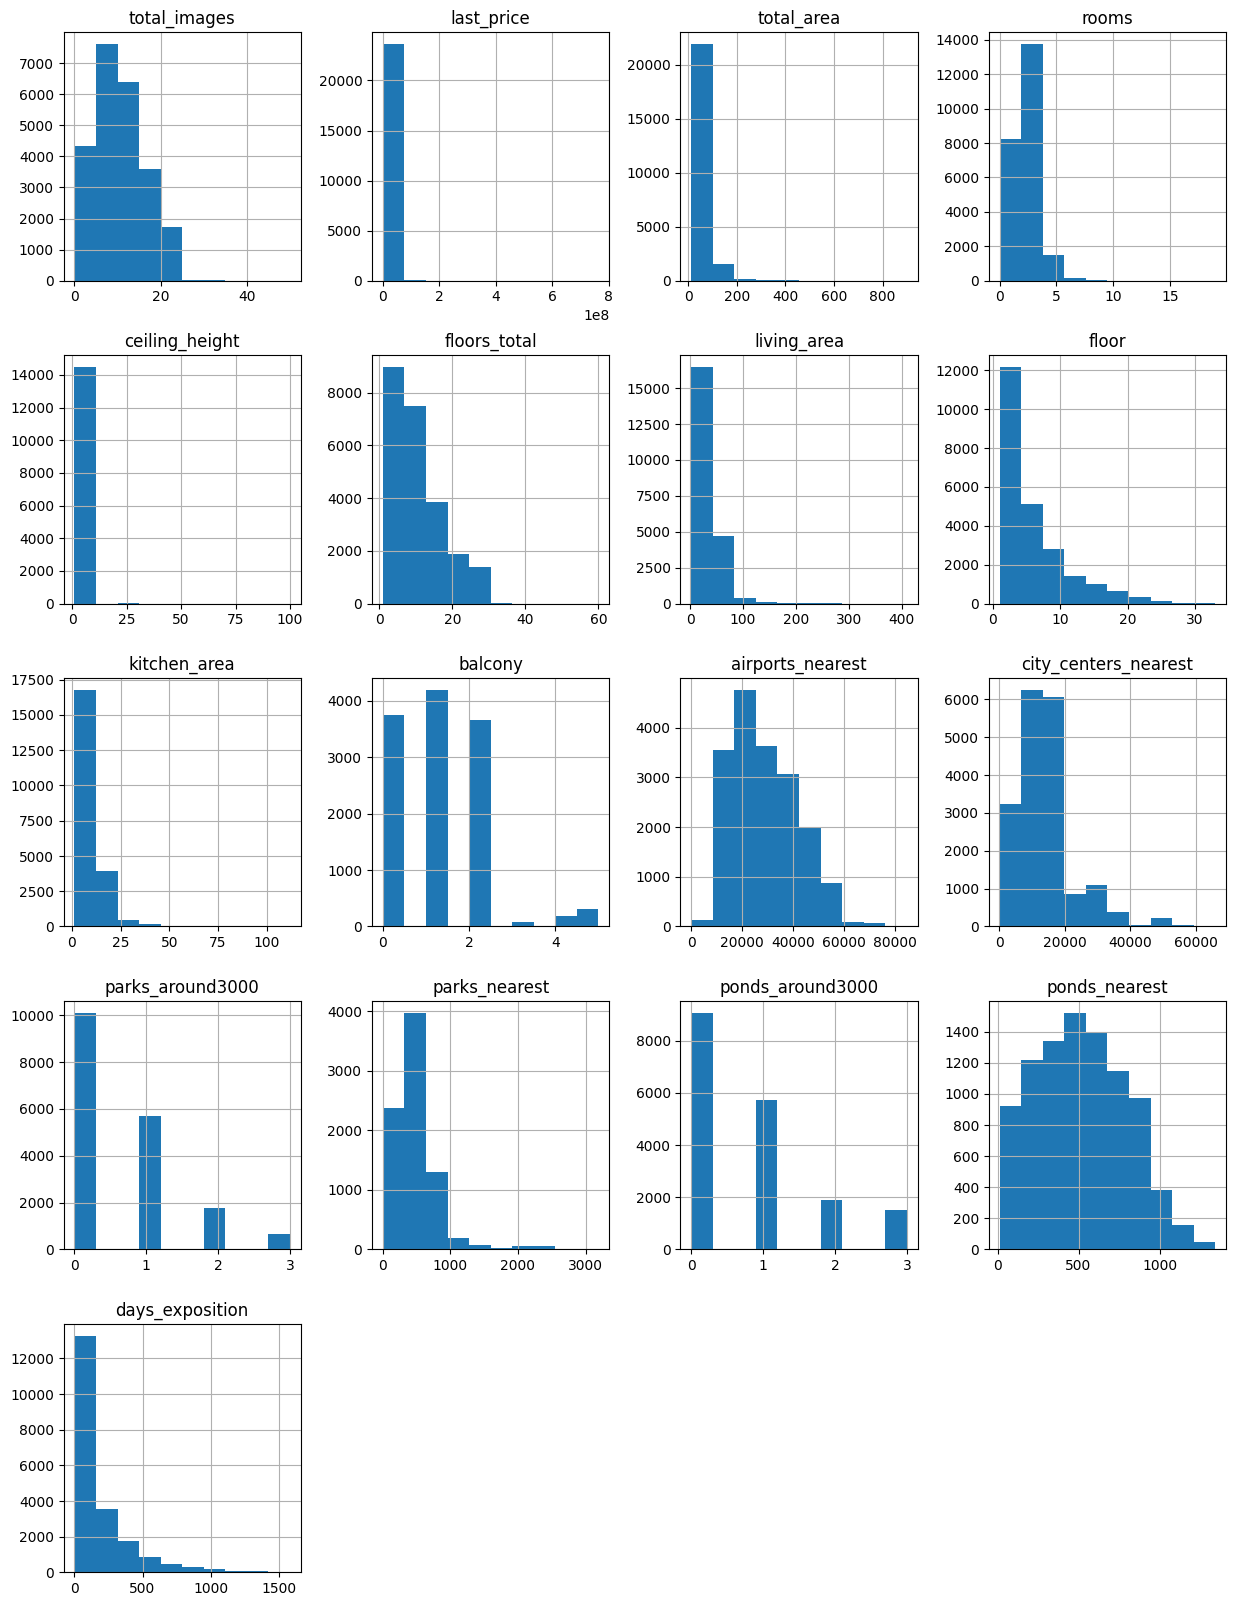

In [10]:
data.hist(figsize=(15, 20));

По гистограмам пока сложно сделать выводы, для начала избавимся от пропусков.

### Предобработка данных

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Рассмотрим все колонки с пропусками по отдельности.
Начнем с 'ceiling_height' - высоты потолков.



In [12]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Значение max - 100м, это явно ошибка в данных, таких потолков не бывает. Так как в столбце явно имеются выбросы, то сначала удалим аномалии, а затем пропущенные значения заполним медианным значением. Происхождение пропусков очевидно: авторы объявлений не знали высоты потолков и посчитали это не самым важным параметром.

In [13]:
data[data['ceiling_height'] > 10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,...,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000.0,50.0,2017-08-08T00:00:00,2,26.0,9.0,21.3,3,NaN,...,7.0,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
6246,6,3300000.0,44.4,2019-03-25T00:00:00,2,25.0,5.0,31.3,5,NaN,...,5.7,NaN,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9379,5,3950000.0,42.0,2017-03-26T00:00:00,3,25.0,5.0,30.0,2,NaN,...,5.2,NaN,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN


Получаем 25 объявлений, где высота потолков больше 10 метров, в большинстве объектов этот параметр в диапазоне 14 - 32 метра, можно предположить, что на самом деле все эти измерения должны быть в 10 раз меньше. А вот квартиру с высотой потолков 100 метров можно удалить.

In [14]:
data = data.drop(index=22869)
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10, 'ceiling_height'] / 10

Теперь заполним пропуски медианой.

In [15]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Также можно заметить, что минимальная высота потолков - 1 м, что тоже не похоже на правду. Удалим строки с высотой полков менее 2 метров.

In [16]:
data = data.loc[data['ceiling_height'] >= 2]

Далее столбец 'floors_total'. Пропуски явно вызваны человеческим фактором: поленились заполнять эту графу или посчитали эту информацию бесполезной

In [17]:
data['floors_total'].describe()

count    23607.000000
mean        10.672894
std          6.595309
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

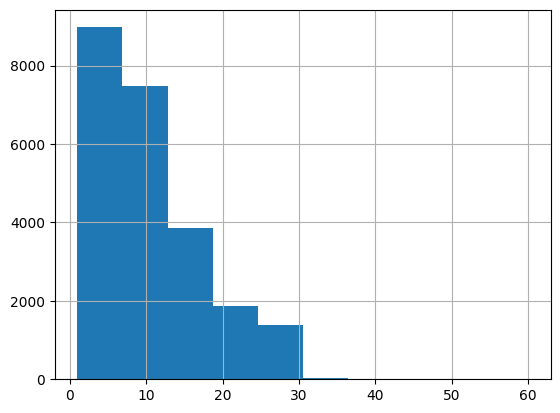

In [18]:
data['floors_total'].hist();

In [19]:
data['floors_total'].value_counts().sort_index()

1.0       25
2.0      382
3.0      668
4.0     1200
5.0     5787
6.0      914
7.0      592
8.0      390
9.0     3761
10.0    1174
11.0     203
12.0    1361
13.0     229
14.0     552
15.0     365
16.0    1375
17.0     833
18.0     505
19.0     339
20.0     271
21.0     158
22.0     286
23.0     352
24.0     469
25.0    1075
26.0     124
27.0     164
28.0      21
29.0       1
33.0       1
34.0       1
35.0      24
36.0       3
52.0       1
60.0       1
Name: floors_total, dtype: int64

In [20]:
data['floors_total'].isna().sum()

86

Всего 86 пропусков. Думаю, если заполнить их медианой, ничего плохого не случится.

In [21]:
data['floors_total'] = data['floors_total'].fillna(9)

Аномалий в данных не обнаружено, хотя конечно 60 этажей в доме звучит странно, но если этот дом находится в Деловом центре в Москве, то почему бы и нет. Смущает тип столба - float, хотя хранит он целые значения. Поменяем:

In [22]:
data.floors_total = data.floors_total.astype('int64')


Далее работаем со столбцом 'living_area'

In [23]:
data['living_area'].describe()

count    21790.000000
mean        34.460952
std         22.032306
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [24]:
data['living_area'].isna().sum()

1903

Природа пропусков понятна - скорее всего, владельцы не знали значение этого параметра и поленились его высчитывать.

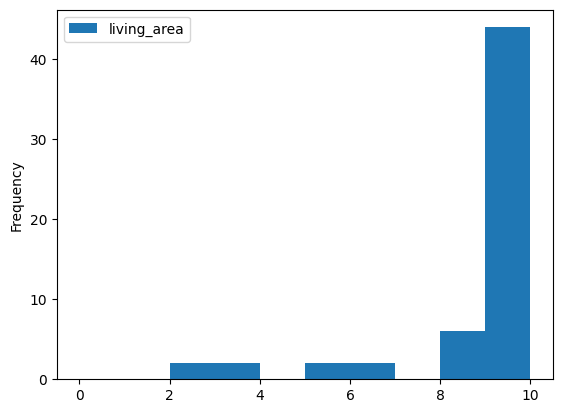

In [26]:
data.plot(y=['living_area'], kind='hist', range=(0, 10));

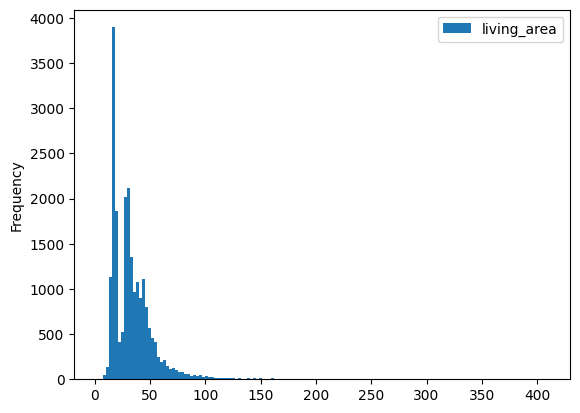

In [27]:
data.plot(y=['living_area'], kind='hist', bins=150);

In [28]:
data['living_area'].value_counts().sort_index()

2.0      2
3.0      2
5.0      1
5.4      1
6.0      1
        ..
322.3    1
332.0    1
347.5    1
409.0    1
409.7    1
Name: living_area, Length: 1782, dtype: int64

Идея такая: высчитываем медианное отношение жилой площади к общей, затем в пропущенных значениях умножаем общую площадь на этот процент.

In [29]:
data['liv_per'] = data['living_area'] / data['total_area']
med = data['liv_per'].median()
data['living_area'] = data['living_area'].fillna(med*data['total_area'])

In [30]:
data[data['living_area'] < 10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,liv_per
114,5,4000000.0,21.40,2019-02-07T00:00:00,1,2.90,8,8.300000,7,NaN,...,NaN,Санкт-Петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN,0.387850
680,14,7200000.0,43.00,2017-10-31T00:00:00,1,2.65,8,9.000000,2,NaN,...,NaN,Санкт-Петербург,23900.0,5232.0,1.0,2137.0,1.0,933.0,296.0,0.209302
1326,8,8100000.0,52.00,2017-01-29T00:00:00,2,2.70,25,9.000000,15,NaN,...,2.0,Санкт-Петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,337.0,0.173077
2309,10,4200000.0,62.40,2017-06-15T00:00:00,2,2.60,9,8.400000,6,NaN,...,2.0,посёлок Шушары,23662.0,29448.0,0.0,NaN,0.0,NaN,111.0,0.134615
3242,7,4440000.0,41.00,2017-07-02T00:00:00,1,2.65,17,3.000000,17,NaN,...,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0,0.073171
4100,17,5300000.0,34.80,2017-06-19T00:00:00,1,2.70,23,9.000000,15,NaN,...,0.0,Санкт-Петербург,33626.0,13495.0,0.0,NaN,0.0,NaN,30.0,0.258621
4542,12,3300000.0,18.00,2018-11-07T00:00:00,1,3.50,5,9.000000,2,NaN,...,NaN,Санкт-Петербург,25157.0,4948.0,2.0,349.0,1.0,963.0,9.0,0.500000
7312,8,3400000.0,27.00,2018-02-21T00:00:00,2,2.50,15,9.000000,4,NaN,...,NaN,Санкт-Петербург,50246.0,16444.0,1.0,617.0,0.0,NaN,NaN,0.333333
8325,9,4800000.0,52.00,2017-10-25T00:00:00,2,2.65,5,9.000000,2,NaN,...,1.0,Санкт-Петербург,33358.0,13171.0,0.0,NaN,2.0,118.0,119.0,0.173077
12040,5,1900000.0,15.00,2018-06-27T00:00:00,1,2.50,5,8.517898,1,NaN,...,NaN,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN


Далее видим аномально низкие значения, например 2 квадратных метра. Такого точно не может быть. Удалим 31 строку, в которых жилая площадь менее 10 квадратных метров.

In [31]:
data = data[data['living_area'] >= 10]

Переходим к столбцу 'is_apartment'

In [32]:
data['is_apartment'].isna().sum()

20890

In [33]:
data['is_apartment'].value_counts()

False    2723
True       49
Name: is_apartment, dtype: int64

Скорее всего, пропуски в этом столбце можно рассматривать как False, просто продавец, не указывая значения, имел ввиду нет, так что заполним пропуски False.

In [34]:
data['is_apartment'] = data['is_apartment'].fillna(False)

C:\Users\pivka\AppData\Local\Temp\ipykernel_7904\2052809825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_apartment'] = data['is_apartment'].fillna(False)


Далее - 'kitchen_area'

In [35]:
data['kitchen_area'].describe()

count    21394.000000
mean        10.562405
std          5.897977
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

С пропусками в этом столбце поступим также, как и с living_area. Причина появления - скорее всего хозяева квартиры не знают эту метрику.

In [36]:
data['kit_per'] = data['kitchen_area'] / data['total_area']
med = data['kit_per'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(med*data['total_area'])

C:\Users\pivka\AppData\Local\Temp\ipykernel_7904\2530254406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['kit_per'] = data['kitchen_area'] / data['total_area']
C:\Users\pivka\AppData\Local\Temp\ipykernel_7904\2530254406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['kitchen_area'] = data['kitchen_area'].fillna(med*data['total_area'])


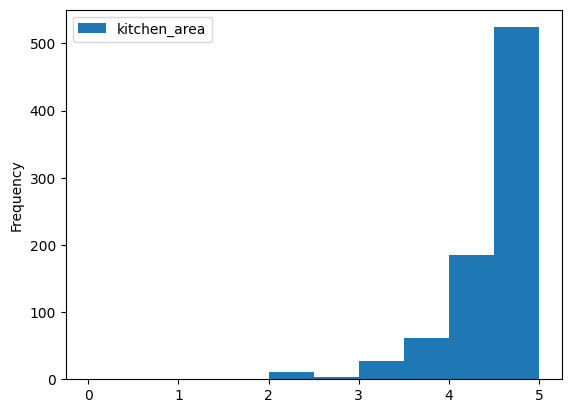

In [37]:
data.plot(y='kitchen_area', kind='hist', range=(0, 5));

Видим, что есть немного кухонь с площадью меньше 2 квадратных метров. Это аномально маленькие кухни, избавимся от таких данных.

In [38]:
data[data['kitchen_area'] < 2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,liv_per,kit_per
20217,7,4250000.0,28.5,2019-05-01T00:00:00,1,2.8,14,19.5,10,False,...,Санкт-Петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN,0.684211,0.045614


In [39]:
data = data[data['kitchen_area'] >= 2]

Следующий столбец - 'balcony'

In [40]:
data['balcony'].isna().sum()

11495

In [41]:
data['balcony'].value_counts()

1.0    4191
0.0    3755
2.0    3653
5.0     303
4.0     183
3.0      81
Name: balcony, dtype: int64

Очевидно, что если составитель объявления не заполнил графу о балконах, то их скорее всего нет. Поэтому просто заполним пропуски нулями.

In [42]:
data['balcony'] = data['balcony'].fillna(0)

C:\Users\pivka\AppData\Local\Temp\ipykernel_7904\2234501656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['balcony'] = data['balcony'].fillna(0)


Также заметим, что тип столбца float, хотя хранит он целые значения. Поменяем:

In [43]:
data['balcony'] = data['balcony'].astype('int64')

C:\Users\pivka\AppData\Local\Temp\ipykernel_7904\1058463596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['balcony'] = data['balcony'].astype('int64')


Переходим к столбцу 'locality_name'

In [44]:
data['locality_name'].isna().sum()

49

Совсем немного пропусков. Можно их удалить, так как они будут мешать дальнейшему анализу. Их наличие очень странно, скорее всего автор оюъявляения по ошибке не указал населенный пункт. Заполнить нечем, так как столбец содержит категориальные данные. Лучше попробуем избавиться от дубликатов.

In [45]:
data = data.dropna(subset=['locality_name'])

In [46]:
len(data['locality_name'].unique())

364

Итак, сейчас имеем 364 уникальных значений в столбце. Идея в том, чтобы отделить названия от прочих слов(посёлок и т.д.), затем создать словарь, где старому значению будет ставится в соответствие новое, затем методом replace поменять значения в колонке.

In [47]:
name_dict = {}
for name in list(data['locality_name'].unique()):
    str_name = name
    name = name.split(' ')
    true_name = []
    for i in name:
        if i[0].isupper():
            true_name.append(i)
    true_name = ' '.join(true_name)
    name_dict[str_name] = true_name
for old_name, new_name in name_dict.items():
    data['locality_name'] = data['locality_name'].replace(old_name, new_name)

In [48]:
sorted(data['locality_name'].unique())

['Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпосёлок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичёво',
 'Иссад',
 'Калитино',

In [49]:
city_to_replace = {'Кингисеппский': 'Кингисепп', 
                   'Коммунар': 'Коммунары', 
                   'Кузьмоловский': 'Кузьмолово', 
                   'Никольский': 'Никольское', 
                   'Сапёрное': 'Сапёрный'}
for old_name, new_name in city_to_replace.items():
    data['locality_name'] = data['locality_name'].replace(old_name, new_name)
len(data['locality_name'].unique())

300

Целых 64 повторяющихся значений!

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23612 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23612 non-null  int64  
 1   last_price            23612 non-null  float64
 2   total_area            23612 non-null  float64
 3   first_day_exposition  23612 non-null  object 
 4   rooms                 23612 non-null  int64  
 5   ceiling_height        23612 non-null  float64
 6   floors_total          23612 non-null  int64  
 7   living_area           23612 non-null  float64
 8   floor                 23612 non-null  int64  
 9   is_apartment          23612 non-null  bool   
 10  studio                23612 non-null  bool   
 11  open_plan             23612 non-null  bool   
 12  kitchen_area          23612 non-null  float64
 13  balcony               23612 non-null  int64  
 14  locality_name         23612 non-null  object 
 15  airports_nearest   

In [51]:
data.airports_nearest.describe()

count    18081.000000
mean     28802.384160
std      12641.525023
min          0.000000
25%      18573.000000
50%      26752.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Так, сразу видно минимальное значение 0, это аномально. Для начала разберемся с пропусками. Скорее всего они появились потому, что некоторые населенные пункты слишком удалены от аэропортов и карты не смогли построить до них маршрут. Сгруппируем данные по населенным пунктам и по каждой группе возьмем медиану, ей заполним пропуски для объектов в каждой граппе.

In [52]:
def insert_med(values):
    air_med = data.pivot_table(index='locality_name', values=values, aggfunc=['median'], dropna=False)
    air_med.columns = ['median']
    air_med = air_med['median']
    for name in air_med.index:
        data.loc[data['locality_name'] == name, values] = data.loc[data['locality_name'] == name, values].fillna(air_med[name])
insert_med('airports_nearest')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23612 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23612 non-null  int64  
 1   last_price            23612 non-null  float64
 2   total_area            23612 non-null  float64
 3   first_day_exposition  23612 non-null  object 
 4   rooms                 23612 non-null  int64  
 5   ceiling_height        23612 non-null  float64
 6   floors_total          23612 non-null  int64  
 7   living_area           23612 non-null  float64
 8   floor                 23612 non-null  int64  
 9   is_apartment          23612 non-null  bool   
 10  studio                23612 non-null  bool   
 11  open_plan             23612 non-null  bool   
 12  kitchen_area          23612 non-null  float64
 13  balcony               23612 non-null  int64  
 14  locality_name         23612 non-null  object 
 15  airports_nearest   

Стало лучше, но не сильно. Пропусков осталось много. Пока оставим как есть. 

In [53]:
data.airports_nearest.value_counts().sort_index()

0.0        1
6450.0     2
6914.0     1
6949.0     1
6989.0     6
          ..
83758.0    1
84006.0    1
84665.0    1
84853.0    1
84869.0    1
Name: airports_nearest, Length: 8253, dtype: int64

Видим единственное странное значение - 0, удалим его.

In [54]:
data = data[data['airports_nearest'] != 0]

Дальше пропуски в столбцах 'city_center_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' можно заполнить по такому же принциау, как и в 'airports_nearest'. Причина возникновнения таких пропусков одинакова - скорее всего карты либо не смогли построить маршрут, либо рассчитать его протяженность.

In [55]:
cols = ['city_centers_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']
for col in cols:
    insert_med(col)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23611 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23611 non-null  int64  
 1   last_price            23611 non-null  float64
 2   total_area            23611 non-null  float64
 3   first_day_exposition  23611 non-null  object 
 4   rooms                 23611 non-null  int64  
 5   ceiling_height        23611 non-null  float64
 6   floors_total          23611 non-null  int64  
 7   living_area           23611 non-null  float64
 8   floor                 23611 non-null  int64  
 9   is_apartment          23611 non-null  bool   
 10  studio                23611 non-null  bool   
 11  open_plan             23611 non-null  bool   
 12  kitchen_area          23611 non-null  float64
 13  balcony               23611 non-null  int64  
 14  locality_name         23611 non-null  object 
 15  airports_nearest   

Рассмотрим последний столбец - 'days_exposition'. В нем достаточно много пропусков, однако заполнять их не будем, скорее всего они появились в результате какой - то технической ошибки при сборе данных.

In [56]:
data['days_exposition'].isna().sum()

3176

Изменим типы данных там, где еще это не сделали. Столбцы 'parks_around3000', 'ponds_around3000', 'days_exposition' должны быть типа int64, так как содержат целочисленные значения. Однако, так как мы оставили пропущенные значения в столбце days_exposition, то изменить тип на int не получится. Оставим float. Также у столбца 'first_day_explosition' должен быть тип datetime. Вроде во всех оставшихся ячейках нормальный тип данных.

In [57]:
cols = ['parks_around3000', 'ponds_around3000']
for col in cols:
    data[col] = data[col].astype('Int64')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,liv_per,kit_per
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,Шушары,12817.0,18603.0,0,NaN,0,584.5,81.0,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,90.289724,9,False,...,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.300000,3,False,...,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,0.547792,0.103356
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.000000,4,False,...,Тосно,NaN,NaN,<NA>,NaN,<NA>,NaN,45.0,0.644068,0.144068
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.700000,1,False,...,Рождествено,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,0.523810,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,43.583247,12,False,...,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602.0,NaN,0.303583


Теперь изучим оставшиеся столбцы на аномалии.

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23611 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23611 non-null  int64         
 1   last_price            23611 non-null  float64       
 2   total_area            23611 non-null  float64       
 3   first_day_exposition  23611 non-null  datetime64[ns]
 4   rooms                 23611 non-null  int64         
 5   ceiling_height        23611 non-null  float64       
 6   floors_total          23611 non-null  int64         
 7   living_area           23611 non-null  float64       
 8   floor                 23611 non-null  int64         
 9   is_apartment          23611 non-null  bool          
 10  studio                23611 non-null  bool          
 11  open_plan             23611 non-null  bool          
 12  kitchen_area          23611 non-null  float64       
 13  balcony         

In [59]:
data.total_images.describe()

count    23611.000000
mean         9.862818
std          5.681489
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

В столбце total_images нет аномалий, двигаемся дальше.

In [60]:
data.last_price.describe()

count    2.361100e+04
mean     6.541836e+06
std      1.089801e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

В столбце 'last_price' мы видим огромный разброс цен, от 12000 до 763.000.000 рублей. 

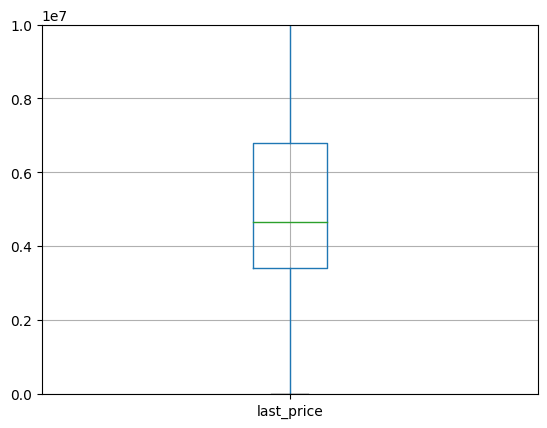

In [61]:
plt.ylim(0, 10000000)
data.boxplot('last_price');

In [62]:
data[data['last_price'] > 100000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,liv_per,kit_per
793,20,135000000.0,310.0,2018-05-22,4,3.30,5,250.000000,2,False,...,Санкт-Петербург,34159.0,7251.0,2,295.0,3,190.0,342.0,0.806452,0.161290
1026,20,155000000.0,310.0,2018-10-12,5,5.30,3,190.000000,3,False,...,Санкт-Петербург,24899.0,4785.0,0,460.0,1,603.0,NaN,0.612903,0.203226
1188,20,118000000.0,290.6,2018-06-01,6,3.82,6,188.700000,3,False,...,Санкт-Петербург,25309.0,6224.0,1,217.0,0,503.0,316.0,0.649346,0.075705
1300,14,120000000.0,280.0,2018-07-12,5,4.70,4,162.000000,3,False,...,Санкт-Петербург,24680.0,4247.0,1,464.0,3,339.0,225.0,0.578571,0.107143
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.000000,5,False,...,Санкт-Петербург,23011.0,1197.0,3,519.0,3,285.0,233.0,0.500000,0.210526
1928,11,125000000.0,224.5,2017-01-24,4,2.65,4,163.500000,3,False,...,Санкт-Петербург,22805.0,2335.0,0,460.0,2,497.0,174.0,0.728285,0.133630
2243,9,130278280.0,304.0,2015-07-24,5,3.11,9,172.629409,7,False,...,Санкт-Петербург,25593.0,5913.0,2,164.0,0,503.0,599.0,NaN,NaN
2536,16,159984000.0,242.4,2015-08-27,4,3.85,9,131.000000,7,False,...,Санкт-Петербург,21946.0,2242.0,1,679.0,1,227.0,501.0,0.540429,0.082508
3117,19,140000000.0,631.0,2019-03-30,7,2.65,5,358.319596,5,False,...,Санкт-Петербург,25707.0,4972.0,0,460.0,2,210.0,NaN,NaN,0.095087
4996,20,124000000.0,124.5,2017-10-12,4,3.00,4,67.200000,2,False,...,Санкт-Петербург,20399.0,1722.0,3,302.0,3,172.0,45.0,0.539759,0.160643


Несмотря на то, что ящик с усами считает все цены, выше 10 миллионов, выбросами, я думаю, что это нормально и такие данные удаляться не должны: им соответствуют и огромные площади, и хорошие расположения, недалеко от центра Питера.

In [63]:
data.total_area.describe()

count    23611.000000
mean        60.365958
std         35.668401
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

Аномалий тут нет.

В столбце 'first_day_exposition' аномалий быть не может.

In [64]:
data.rooms.describe()

count    23611.000000
mean         2.071323
std          1.078689
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [65]:
data.rooms.value_counts().sort_index()

0      195
1     8011
2     7914
3     5796
4     1174
5      326
6      105
7       59
8       12
9        8
10       3
11       2
12       1
14       2
15       1
16       1
19       1
Name: rooms, dtype: int64

In [66]:
data[data['rooms'] > 9]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,liv_per,kit_per
648,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.8,7,False,...,Санкт-Петербург,23606.0,3148.0,0,460.0,0,503.0,NaN,0.755580,0.072401
866,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.0,4,False,...,Санкт-Петербург,38076.0,7950.0,0,460.0,2,435.0,418.0,0.611570,0.045730
4149,6,23000000.0,272.6,2018-01-11,10,3.14,7,145.9,7,False,...,Санкт-Петербург,10726.0,12169.0,1,191.0,1,531.0,NaN,0.535216,0.068966
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6,409.0,3,False,...,Санкт-Петербург,24447.0,4666.0,1,767.0,0,503.0,14.0,0.693220,0.169492
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5,129.0,2,False,...,Санкт-Петербург,21469.0,1015.0,1,686.0,2,66.0,813.0,0.664606,0.061309
14498,6,32250000.0,374.6,2018-06-09,19,2.65,5,264.5,2,False,...,Санкт-Петербург,19497.0,3574.0,0,460.0,2,548.0,114.0,0.706086,0.073679
18119,4,15500000.0,216.1,2016-07-04,10,3.15,5,161.4,2,False,...,Санкт-Петербург,24353.0,4921.0,1,368.0,0,503.0,11.0,0.746876,0.091624
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4,180.0,4,False,...,Санкт-Петербург,23575.0,4142.0,1,516.0,0,503.0,1365.0,0.666667,0.048148
18891,11,40000000.0,290.0,2016-06-21,10,3.50,6,189.4,6,False,...,Санкт-Петербург,26229.0,4932.0,3,316.0,1,227.0,77.0,0.653103,0.103448
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25,409.7,25,False,...,Санкт-Петербург,30706.0,7877.0,0,460.0,2,318.0,106.0,0.455222,0.124444


Тут тоже нет аномалий. Даже для объектов с подозрительно большим количеством комнат, потому что там и площадь помещения соотвествующая.

Столбец 'studio' - аномалий нет.

In [67]:
data.studio.value_counts()

False    23464
True       147
Name: studio, dtype: int64

Столбец 'open_plan' - аномалий нет.

In [68]:
data.open_plan.value_counts()

False    23544
True        67
Name: open_plan, dtype: int64

Столбец 'city_centers_nearest'

In [69]:
data.city_centers_nearest.describe()

count    18786.000000
mean     14470.573406
std       8600.923299
min        181.000000
25%       9496.000000
50%      13270.000000
75%      16776.250000
max      65968.000000
Name: city_centers_nearest, dtype: float64

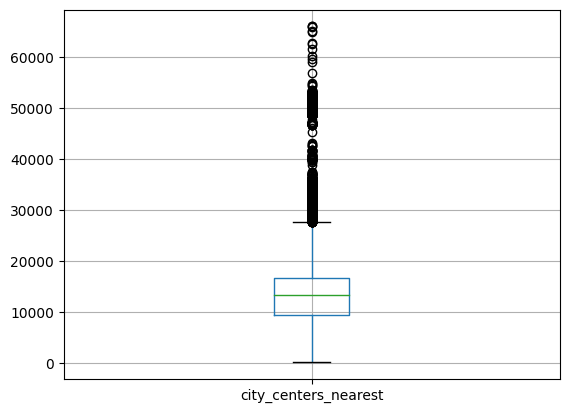

In [71]:
data.boxplot('city_centers_nearest');

Ящик с усами подсказывает, что всё, что дальше 30 километров от центра - аномалии. Я с ним не согласен - в данных есть объекты в разных удаленных поселках, которые вполне могут находиться на значительном удалении от центра города.

In [72]:
data.parks_around3000.describe()

count    18786.000000
mean         0.589375
std          0.795731
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [74]:
data.ponds_around3000.describe()

count    18786.000000
mean         0.807569
std          0.945729
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

В этих двух столбцах нет аномалий, 3 водоема или 3 парка в радиусе 3 километров - обычное дело.

In [75]:
data.parks_nearest.describe()

count    17617.000000
mean       475.926350
std        235.488549
min          1.000000
25%        428.500000
50%        460.000000
75%        460.000000
max       3190.000000
Name: parks_nearest, dtype: float64

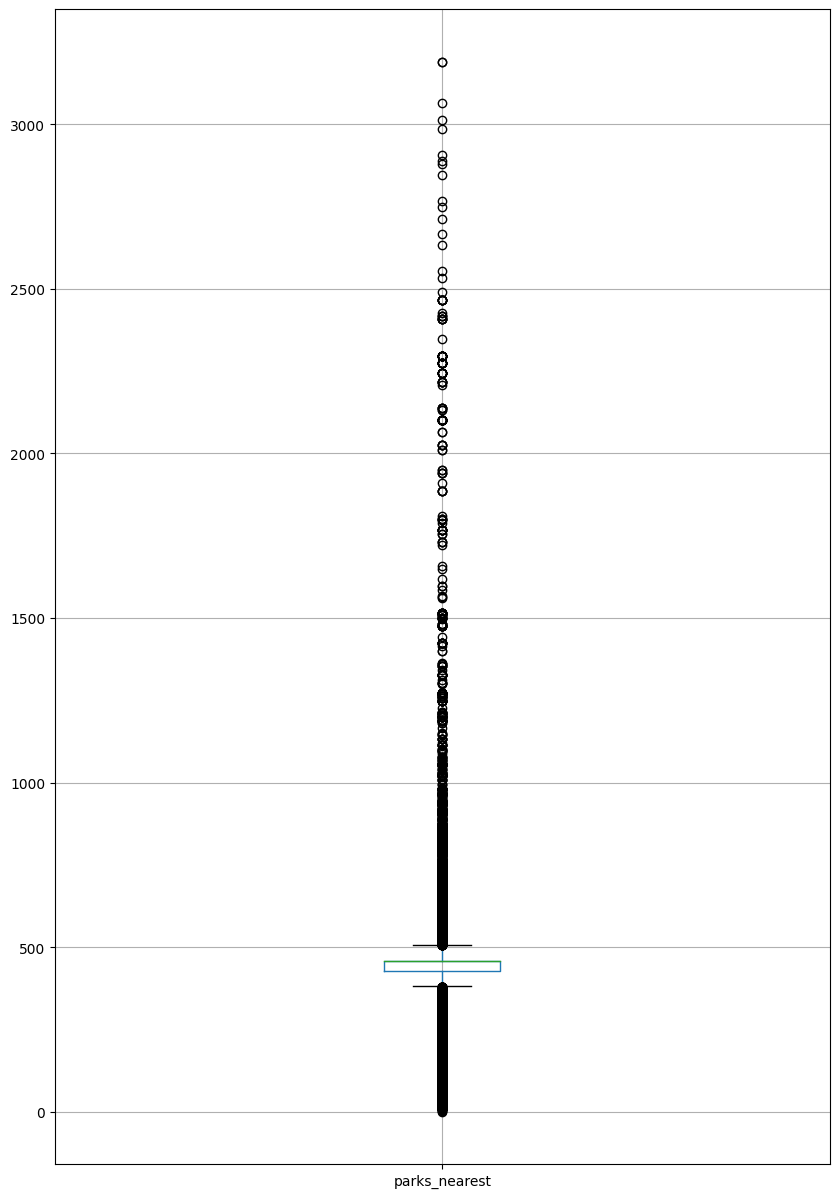

In [77]:
data.boxplot('parks_nearest', figsize=(10, 15));

In [78]:
data[data['parks_nearest'] < 10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,liv_per,kit_per
2527,8,4690000.0,60.3,2016-03-05,2,2.50,5,28.000000,2,False,...,Кронштадт,69775.0,51500.0,3,9.0,3,345.0,146.0,0.464345,0.131012
9344,12,3000000.0,28.1,2017-07-25,1,2.50,9,17.000000,1,False,...,Санкт-Петербург,12051.0,11665.0,1,7.0,1,780.0,440.0,0.604982,0.199288
11949,7,4500000.0,44.0,2017-11-24,2,2.60,9,30.000000,7,False,...,Санкт-Петербург,11806.0,12292.0,1,3.0,1,508.0,82.0,0.681818,0.159091
14624,8,3770000.0,45.4,2019-03-20,2,2.65,9,28.430000,2,False,...,Санкт-Петербург,43932.0,16436.0,1,1.0,0,503.0,42.0,0.626211,0.151982
20193,3,11809670.0,102.6,2017-04-21,3,2.65,9,58.262426,3,False,...,Санкт-Петербург,27562.0,6410.0,2,9.0,2,480.0,90.0,NaN,0.173489
22941,8,10965000.0,69.3,2019-01-10,1,3.00,4,48.900000,4,True,...,Зеленогорск,73391.0,54490.0,3,4.0,1,217.0,110.0,0.705628,NaN


3 километра до парка - в рамках нормы. А вот 1 метр уже странно. Удалим данные с расстоянием до парка меньше 10 метров.

In [79]:
data = data.drop(index=[2527, 9344, 11949, 14624, 20193, 22941])

In [80]:
data.ponds_nearest.describe()

count    18671.000000
mean       498.219779
std        207.205557
min         13.000000
25%        441.000000
50%        503.000000
75%        552.000000
max       1344.000000
Name: ponds_nearest, dtype: float64

С этим столбцом всё в порядке.

In [81]:
data.days_exposition.describe()

count    20429.000000
mean       180.838465
std        219.917019
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Ничего аномального.

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23605 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23605 non-null  int64         
 1   last_price            23605 non-null  float64       
 2   total_area            23605 non-null  float64       
 3   first_day_exposition  23605 non-null  datetime64[ns]
 4   rooms                 23605 non-null  int64         
 5   ceiling_height        23605 non-null  float64       
 6   floors_total          23605 non-null  int64         
 7   living_area           23605 non-null  float64       
 8   floor                 23605 non-null  int64         
 9   is_apartment          23605 non-null  bool          
 10  studio                23605 non-null  bool          
 11  open_plan             23605 non-null  bool          
 12  kitchen_area          23605 non-null  float64       
 13  balcony         

Напоследок удалим добавленные столбцы.

In [83]:
data = data.drop(['liv_per', 'kit_per'], axis=1)

Finally, preprocessing is over.

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23605 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23605 non-null  int64         
 1   last_price            23605 non-null  float64       
 2   total_area            23605 non-null  float64       
 3   first_day_exposition  23605 non-null  datetime64[ns]
 4   rooms                 23605 non-null  int64         
 5   ceiling_height        23605 non-null  float64       
 6   floors_total          23605 non-null  int64         
 7   living_area           23605 non-null  float64       
 8   floor                 23605 non-null  int64         
 9   is_apartment          23605 non-null  bool          
 10  studio                23605 non-null  bool          
 11  open_plan             23605 non-null  bool          
 12  kitchen_area          23605 non-null  float64       
 13  balcony         

Итак, сейчас имеем 364 уникальных значений в столбце. Идея в том, чтобы отделить названия от прочих слов(посёлок и т.д.), затем создать словарь, где старому значению будет ставится в соответствие новое, затем методом replace поменять значения в колонке.

In [85]:
name_dict = {}
for name in list(data['locality_name'].unique()):
    str_name = name
    name = name.split(' ')
    true_name = []
    for i in name:
        if i[0].isupper():
            true_name.append(i)
    true_name = ' '.join(true_name)
    name_dict[str_name] = true_name
for old_name, new_name in name_dict.items():
    data['locality_name'] = data['locality_name'].replace(old_name, new_name)

city_to_replace = {'Кингисеппский': 'Кингисепп', 
                   'Коммунар': 'Коммунары', 
                   'Кузьмоловский': 'Кузьмолово', 
                   'Никольский': 'Никольское', 
                   'Сапёрное': 'Сапёрный'}
for old_name, new_name in city_to_replace.items():
    data['locality_name'] = data['locality_name'].replace(old_name, new_name)

In [86]:
len(data['locality_name'].unique())

300

<div class="alert alert-block alert-info">
Стоит отметить, что неявных дубликатов больше ни в одном столбце быть не может. Можно проверить на явные дубликаты:  
</div>

In [87]:
data.duplicated().sum()

0

<div class="alert alert-block alert-info">
Таковых не имеется.
</div>

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23605 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23605 non-null  int64         
 1   last_price            23605 non-null  float64       
 2   total_area            23605 non-null  float64       
 3   first_day_exposition  23605 non-null  datetime64[ns]
 4   rooms                 23605 non-null  int64         
 5   ceiling_height        23605 non-null  float64       
 6   floors_total          23605 non-null  int64         
 7   living_area           23605 non-null  float64       
 8   floor                 23605 non-null  int64         
 9   is_apartment          23605 non-null  bool          
 10  studio                23605 non-null  bool          
 11  open_plan             23605 non-null  bool          
 12  kitchen_area          23605 non-null  float64       
 13  balcony         

Добавим новые столбцы

In [90]:
data['price_per_metr'] = data['last_price'] / data['total_area']
data['dayweek_of_exposition'] = data['first_day_exposition'].dt.dayofweek
data['month_of_exposition'] = data['first_day_exposition'].dt.month
data['year_of_exposition'] = data['first_day_exposition'].dt.year
def type_of_floor(row):
    if row['floor'] == row['floors_total']:
        return 'Последний'
    elif row['floor'] == 1:
        return 'Первый'
    else:
        return 'Другой'
data['type_of_floor'] = data.apply(type_of_floor, axis=1)
data['distance_center_km'] = data['city_centers_nearest'].apply(lambda x: x / 1000).round()

Все новые данные рассчитаны и добавлены в таблицу

### Исследовательский анализ данных 

#### Изучение параметров

In [91]:
data.total_area.describe()

count    23605.000000
mean        60.366487
std         35.670918
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

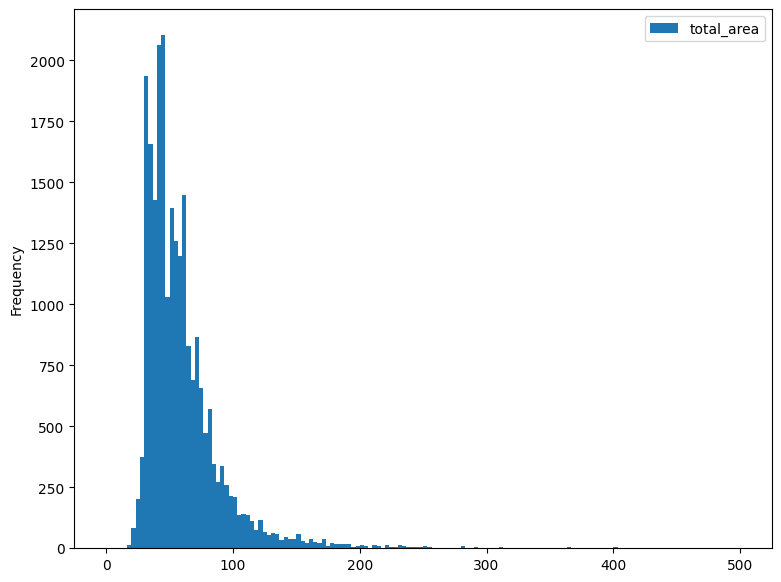

In [93]:
data.plot(y='total_area', kind='hist', bins=150, range=(0, 500), figsize=(9, 7));

Итак, в выборке представлено огромное множество различных экземпляров, от студий в 30 квадратных метров(коих немного), до дворцов в 300-400-500 квадратов(которых тоже очень немного). Ожидаемо подавляющее большинство объектов - одно или двухкомнатные квартиры площадью 50 - 60 квадратных метров. Медиана и среднее близки друг к другу - 52 и 60 квадратных метров соответственно. Распределение подозрительно похоже на пуассоновское. Выбросы конечно имеются, но судя по гистограмме сильно они не влияют на распределение.

In [94]:
data.living_area.describe()

count    23605.000000
mean        34.606028
std         22.342568
min         10.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

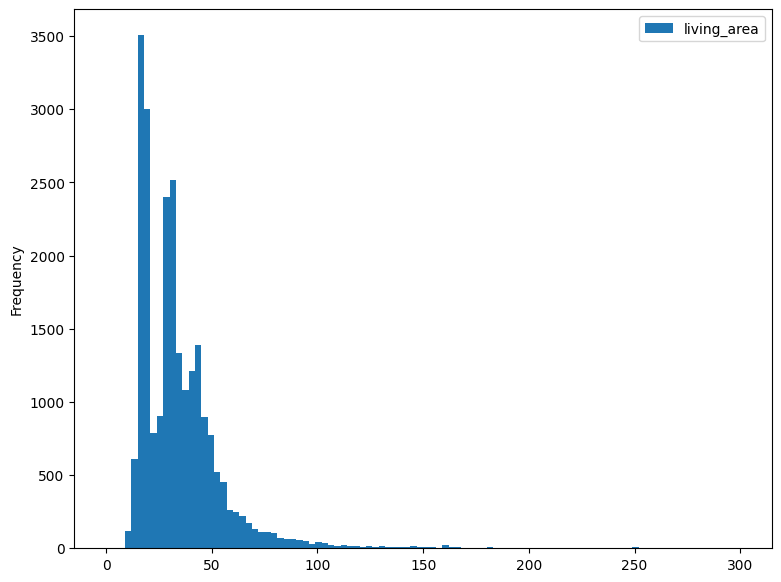

In [96]:
data.plot(y='living_area', kind='hist', bins=100, figsize=(9, 7), range=(0, 300));

Распределение жилой площади почти в точности повторяет распределение квартир по общей площади, что весьма логично. Разве что намного более ярче выражен провал рядом с медианой, но это объяснимо: при сокращении общей площади жилая площадь сокращается еще сильнее. Судя по представленной гистограмме, мы можем либо выбрать дешевую квартиру, но с очень маленькой жилой площадью(большинство находится в пределах 20 квадратных метров), либо готовиться платить много, но иметь много жилой площади - следющий пик, после 20 квадратов, есть только на 40 метрах, то есть средних квартир по этому параметру почти нет! Зато выбор велик: можно найти и 10 квадратных метров, и 400. Распределение наопминает пуассоновское. Выбросы в пределах нормы, как и на гистограмме общей площади.

In [97]:
data.kitchen_area.describe()

count    23605.000000
mean        10.484663
std          6.019216
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

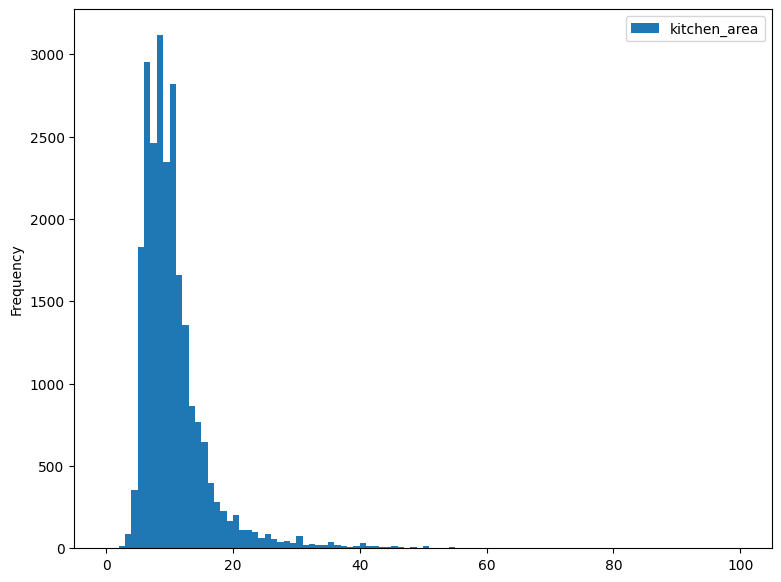

In [99]:
data.plot(y='kitchen_area', kind='hist', bins=100, figsize=(9, 7), range=(0, 100));

По аналогии, распределние площади кухонь аналогично двум прошлым распределениям. Таких сильных провалов, как на жилой площади, тут нет. Максимум приходится примерно на 10 квадратных метров - самая частая площадь кухни в объявлениях. Есть как совсем маленькие экземляры - до 5 квадратных метов, так и огромные кухни в 100 квадратных метров, благо и тех, и тех, немного. В основном преобладают стандартные кухни. Распределение напоминает пуассоновское.

In [100]:
data.last_price.describe()

count    2.360500e+04
mean     6.541858e+06
std      1.089925e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

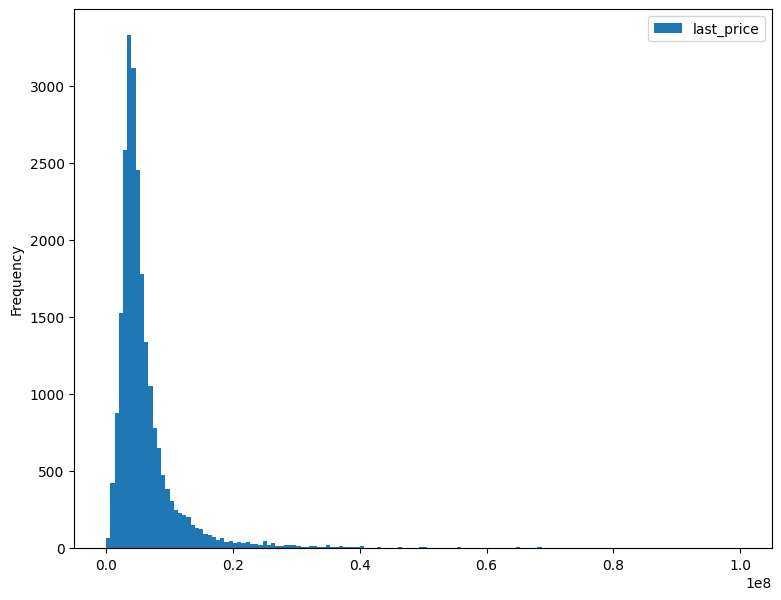

In [101]:
data.plot(y='last_price', kind='hist', bins=150, figsize=(9, 7), range=(0, 100000000));

Очень красивый график. Видим пик на значении 4.650.000, то есть примерно около этой цены находится большинство объвлений. Важно, что пик очень острый, значит количество объявлений со средней ценой очень сильно превосходит количество объявлений с ценами, далекими от медианных. Такие есть. Например квартира за 12.000 или помещение за 763.000.000 в центре Питера. Опять же, выбросы не сильно влияют на распределение, так как их немного по сравнению с обычными объявлениями. Распределение в очередной раз напоминает распределение пуассона. Абсолютно предсказуемо распредление цен напоминает распределения всех прошлых величин. Между ценой и всеми площадями есть сильная корреляция - цена при возрастании общей площади тоже возрастает, также дела обстоят и с кухней и с жилой площадью.

In [102]:
data.rooms.describe()

count    23605.000000
mean         2.071383
std          1.078764
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

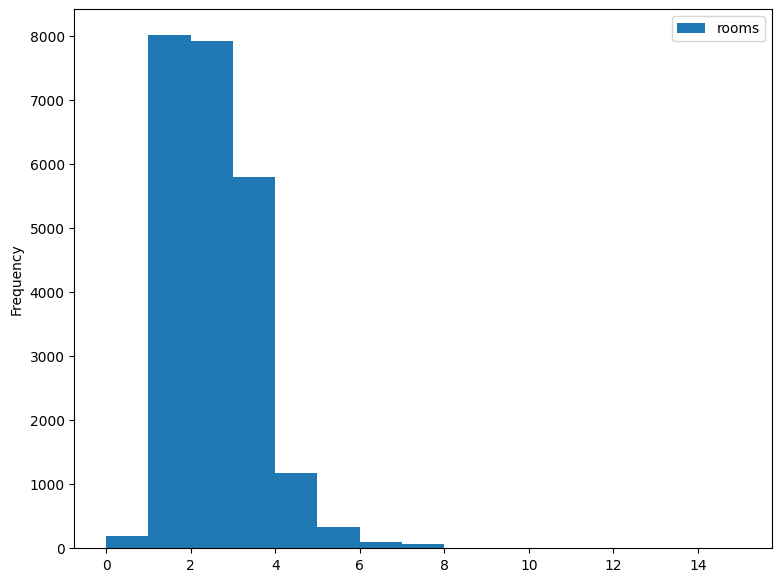

In [103]:
data.plot(y='rooms', kind='hist', bins=15, figsize=(9, 7), range=(0, 15));

Гистограмма сообщает нам, что в основном в объявлениях указаны 2 и 3 комнатные квартиры. Конечно имеются и выбросы: квартиры с 0 комнат, которые я посчитал студиями, и квартиры более чем 10 комнатами, что уже конечно не относится к чему - то стандартному, однако наличие этих значений не влияет на распределение. В очередной раз отмечаем, что распределение похоже на пуассоновское и на распределение площадей и цен! Это доказывает, что количество комнат и цена тоже коррелируют, что логично, ведь при увеличении количества комнат возрастает и метраж квартиры.

In [104]:
data.ceiling_height.describe()

count    23605.000000
mean         2.697657
std          0.231909
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          8.300000
Name: ceiling_height, dtype: float64

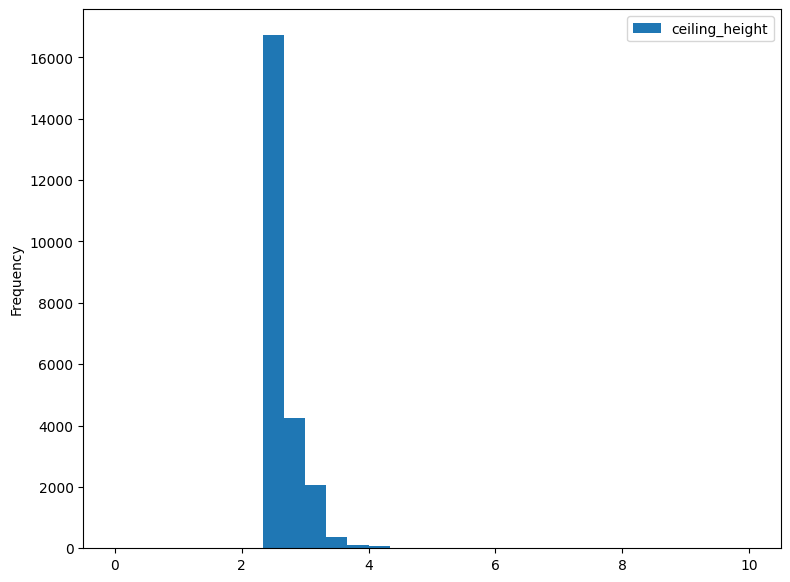

In [105]:
data.plot(y='ceiling_height', kind='hist', bins=30, figsize=(9, 7), range=(0, 10));

Потолки. Абсолютное большинство объявлений предлагают жильё с высотой потолков около 2,5 метров - самая стандартная величина этого параметра. Без выбросов никуда - есть 2 метровые "землянки", есть квартиры с высотой потолков под 8 метров, такое тоже бывает. Распределение опять напоминает распределение цен, и это объяснимо - стандратные квартиры, находящиеся в рамках рынка, имеют и стандартную высоту потолков(чаще всего), именно поэтому пик совпадает на обоих графиках, а вот высокие потолки среди населения ценятся, и такие квартиры заведомо стоят дороже.

In [106]:
data.floor.describe()

count    23605.00000
mean         5.89265
std          4.88154
min          1.00000
25%          2.00000
50%          4.00000
75%          8.00000
max         33.00000
Name: floor, dtype: float64

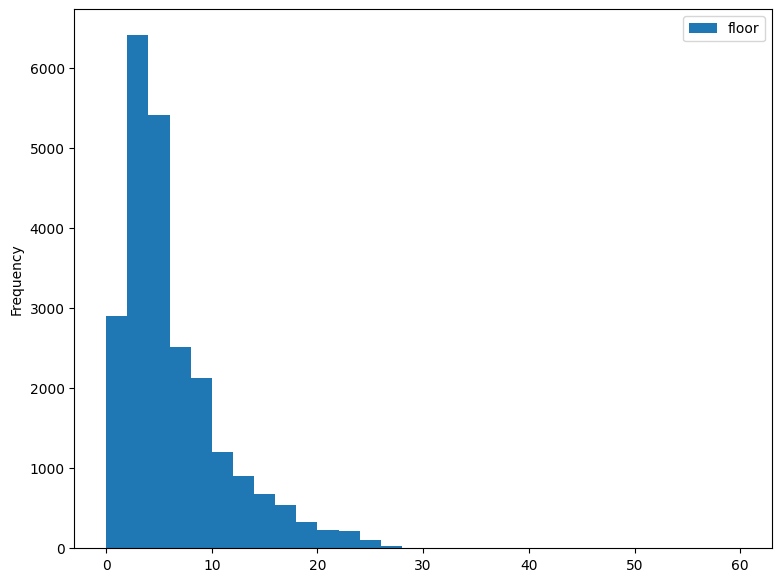

In [107]:
data.plot(y='floor', kind='hist', bins=30, figsize=(9, 7), range=(0, 60));

Большинство квартир находятся на 4 - 5 этаже. Много квартир находятся на первом - думаю среди этих объявлений есть не только квартиры, но и частные дома, так как мы видели много объявлений в различных поселках Ленинградской области. Далее видим плавное повышение этажности. Распределение опять напоминает распределние цен. Всё логично - чем выше этаж, тем дороже цена квартиры. В нашем случае, чем правее мы идем, тем выше этажность - есть и 20, и 30 этаж. Скорее всего это уже элитные жилые комплексы, соответственно и цена жилья там выше.

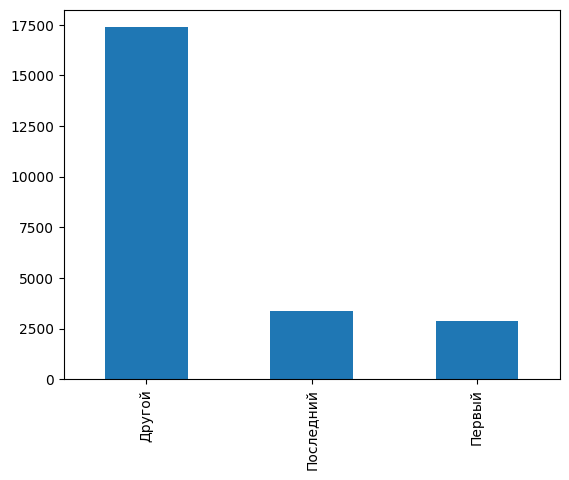

In [108]:
type_of_floor = data['type_of_floor'].value_counts().plot.bar();

Число квартир на первом и на последнем этаже примерно равное, около 2500 объявлений. В основном объявления предлагают объекты на других этажах, как мы выяснили ранее на 4 - 5 этажах.

In [109]:
data.floors_total.describe()

count    23605.000000
mean        10.666935
std          6.580744
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

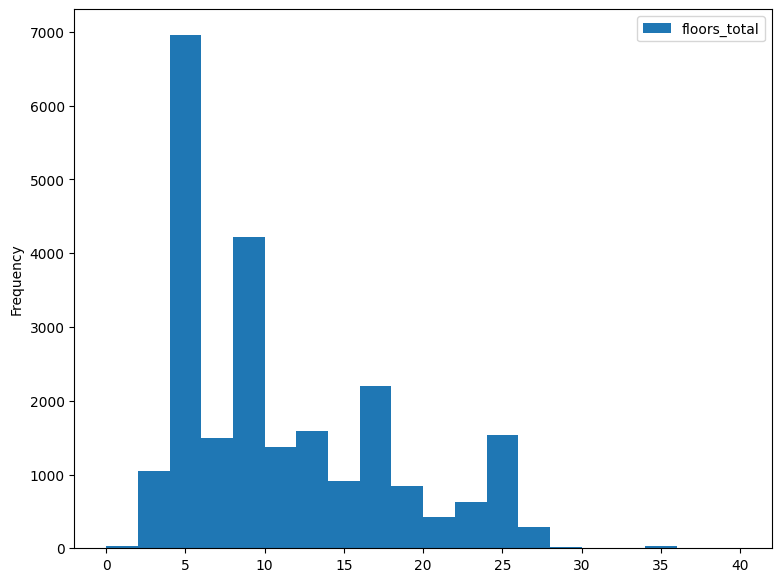

In [110]:
data.plot(y='floors_total', kind='hist', bins=20, figsize=(9, 7), range=(0, 40));

Видно, что основную массу объявлений составляют пятиэтажные дома, затем идут 10 этажные. Также в подтверждение моей теории про частные дома в данных, есть дома с этажностью 1, явно частные. Есть и предложения в небоскрёбах в 60 этажей.

In [111]:
data.city_centers_nearest.describe()

count    18780.000000
mean     14467.060650
std       8592.838099
min        181.000000
25%       9496.000000
50%      13270.000000
75%      16772.750000
max      65968.000000
Name: city_centers_nearest, dtype: float64

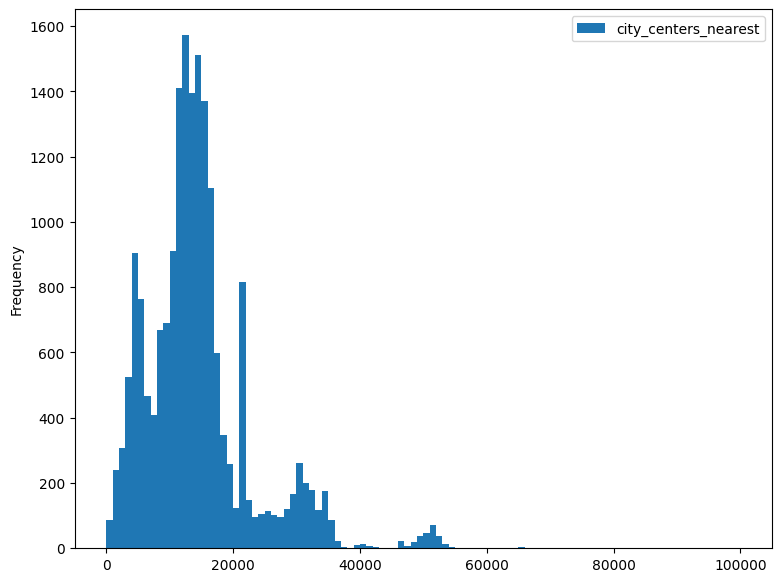

In [112]:
data.plot(y='city_centers_nearest', kind='hist', bins=100, figsize=(9, 7), range=(0, 100000));

Так как большинство объявлений из Санкт - Петербурга, то на графике виден пик примерно в 13 километрах до центра. Преполагаю, что основную часть этих объявлений составляют квартиры из нового Питера(Мурино, Девяткино и прочее). Есть особо близкие к центру места, меньше километра, есть и особо далекие - более 60 км. 

In [113]:
data.airports_nearest.describe()

count    18780.000000
mean     29543.609398
std      13065.305003
min       6450.000000
25%      18808.750000
50%      27217.500000
75%      38795.000000
max      84869.000000
Name: airports_nearest, dtype: float64

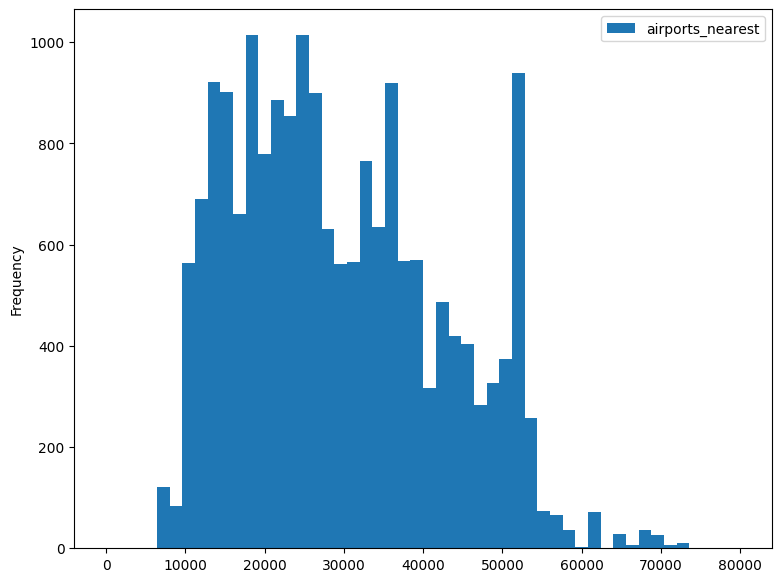

In [114]:
data.plot(y='airports_nearest', kind='hist', bins=50, figsize=(9, 7), range=(0, 80000));

Здесь интересное распределение. Так как аэропорт находится за городом, то до него далеко всем. Основная часть находится на удалении в 20 - 30 километров от аэропорта. Много объявлений и того дальше, наверное это Ленинградская область. Есть и те, кому не так далеко до аэропорта - это скорее всего тоже область, но с той стороны от города, где находится аэропорт.

In [115]:
data.parks_nearest.describe()

count    17611.000000
mean       476.086622
std        235.368481
min         10.000000
25%        428.500000
50%        460.000000
75%        460.000000
max       3190.000000
Name: parks_nearest, dtype: float64

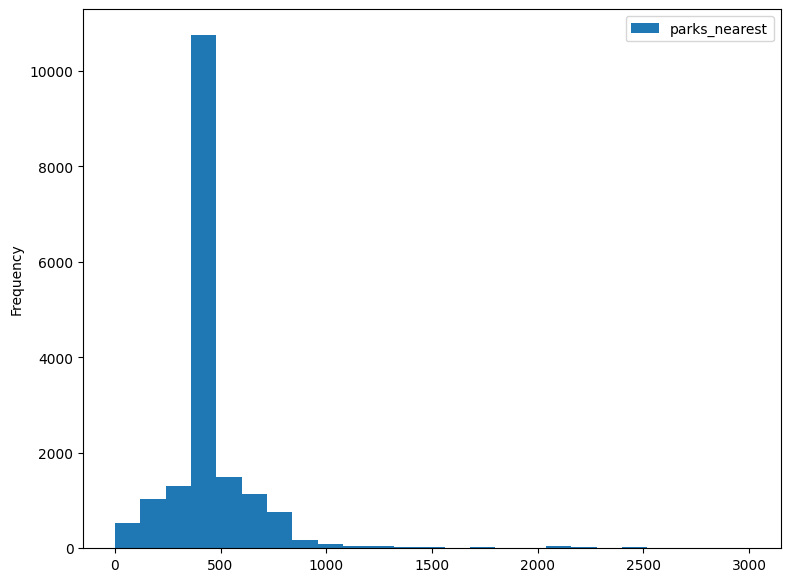

In [116]:
data.plot(y='parks_nearest', kind='hist', bins=25, figsize=(9, 7), range=(0, 3000));

Заметна приятная тенденция - в большинстве случаев до парка около 400 метров. Есть те, кому повезло жить на расстоянии 100 метров от парка, хотя конечно есть объекты с расстоянием до парка более 2 километров.

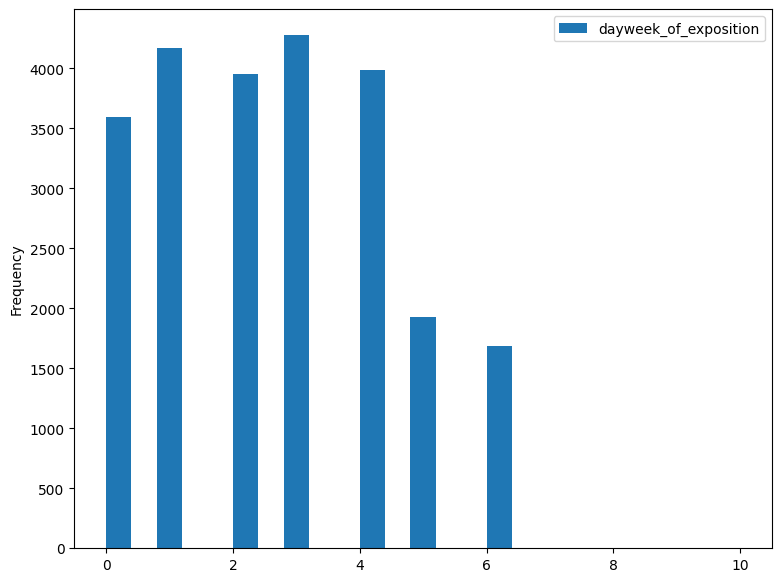

In [117]:
data.plot(y='dayweek_of_exposition', kind='hist', bins=25, figsize=(9, 7), range=(0, 10));

Судя по гистограмме больше всего объявлений было размещено в четверг, а в целом в любой рабочий день размещалось примерно одинаковое количество объявлений. А вот на выходных количество размещенных объявлений резко падало. 

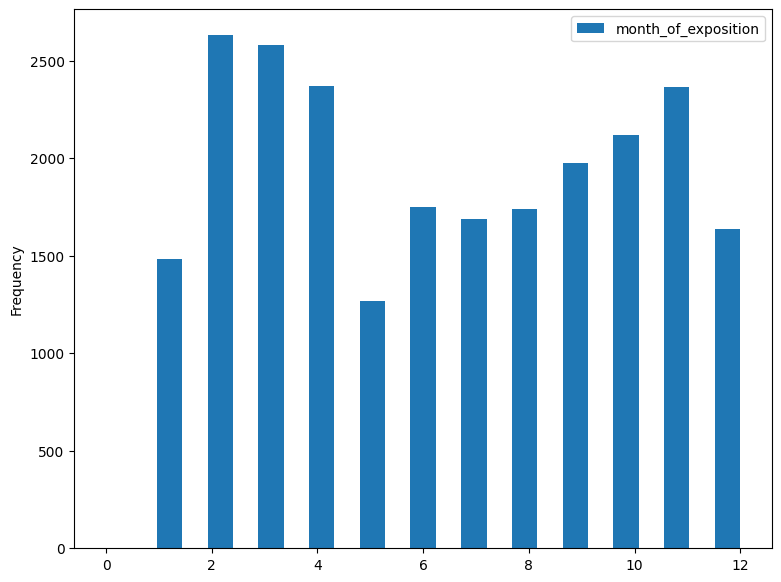

In [118]:
data.plot(y='month_of_exposition', kind='hist', bins=25, figsize=(9, 7), range=(0, 12));

Меньше всего объявлений было выставлено в мае, больше всего - в феврале. С февраля по апрель плавное снижение, а затем резкий провал в мае, затем плавный рост до ноября, и резкое падение в декабре.

**Вывод**

Обнаружена и графически доказана небольшая корреляция между площадью квартиры, количеством комнат, этажом, высотой потолков и ценой квартиры. Представлено очень много разных квартир на разного покупателя: от самых простых и дешевых до огромных и дорогих помещений. В основном представлены двухкомнатные квартиры площадью около 50 квадратных метров, с высотой потолков 2,5 метра, на 4-5 этаже. От квартиры до центра города добираться обычно около 13 км и стоит такое жилье 4,5 - 5 миллионов. Большинство объявлений выкладывается в феврале, в рабочую неделю, чаще в четверг.

#### Изучение продаж квартир

In [119]:
data.days_exposition.describe()

count    20429.000000
mean       180.838465
std        219.917019
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

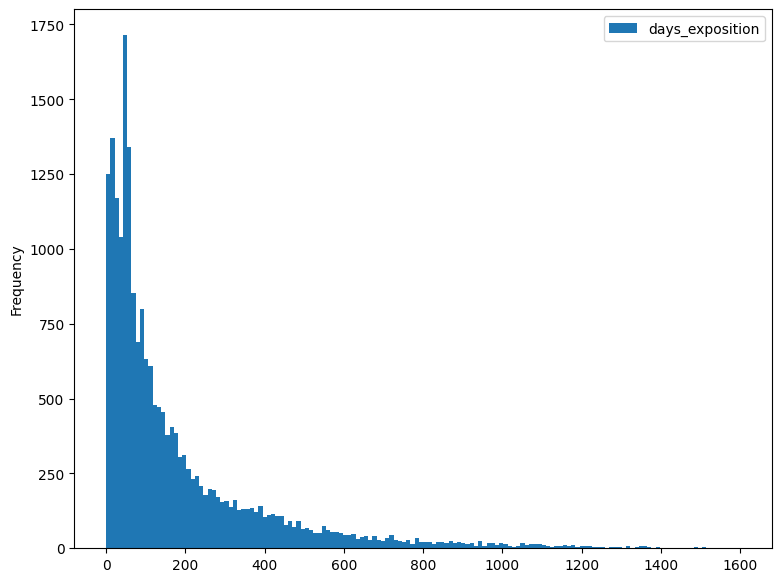

In [120]:
data.plot(y='days_exposition', kind='hist', bins=150, figsize=(9, 7), range=(0, 1600));

Судя по гистограмме и описательным статистикам, самая стандартная продажа занимает около 100 дней. Гистограмма также указывает на слишком долгие и слишком быстрые продажи - например 1 день или 1580 дней. Это явно аномальные значения.

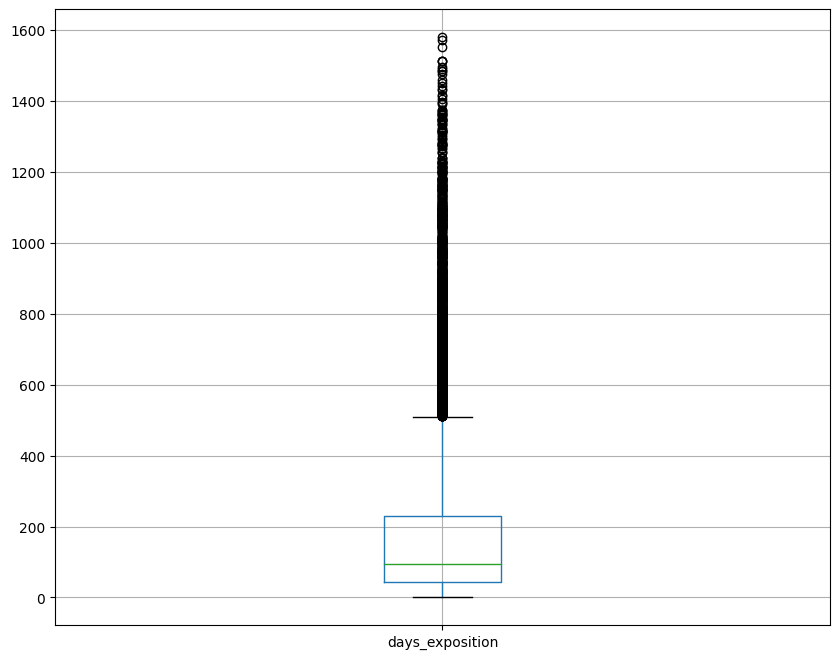

In [122]:
data.boxplot('days_exposition', figsize=(10, 8));

Судя по ящику с усами, аномально долгой продажей считается сделка, длившаяся более 500 дней. А вот аномально быстрых продаж в данных нет.

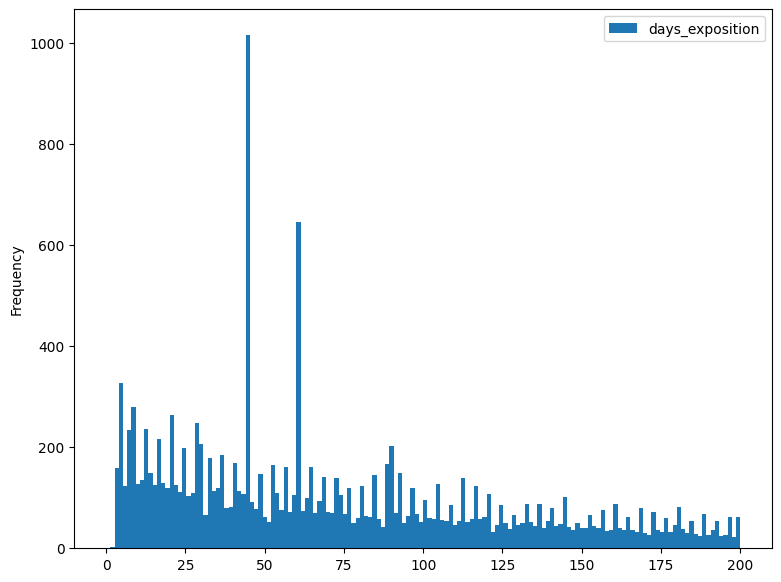

In [124]:
data.plot(y='days_exposition', kind='hist', bins=150, figsize=(9, 7), range=(0, 200));

In [125]:
data['days_exposition'].value_counts().sort_values(ascending=False)

45.0      878
60.0      536
7.0       233
30.0      207
90.0      202
         ... 
1049.0      1
1281.0      1
730.0       1
938.0       1
971.0       1
Name: days_exposition, Length: 1141, dtype: int64

На гистограмме по значениям до 200 заметны странные пики. С помощью метода value_counts() было определено, что пики принадлежат значениям 45, 60 и 90 дней. Вероятнее всего это какие - то ограничения яндекса и люди сами снимали объявления, что бы их не сняла система, а система распознавала это как продажу.

 **Вывод**

Аномально быстрых продаж нет, слишком долгие продажи - дольше 500 дней. В основном объекты продаются примерно за 100 дней. В данных обнаружены аномалии - много объявлений со сроком 45, 60 и 90 дней. На счёт них лучше посоветоваться со сборщиками данных.

#### Факторы, влияющие на цену

In [126]:
def piv_table(col):
    area_price = data.pivot_table(index=col, values='last_price', aggfunc=['median', 'count'])
    area_price.columns=['median', 'count']
    return area_price

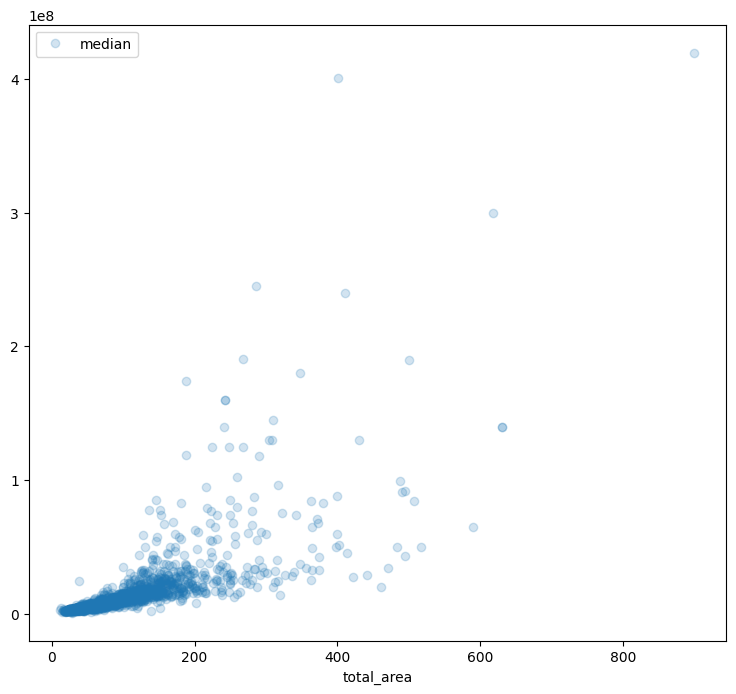

In [129]:
area_price = piv_table('total_area')
area_price.plot(y='median', style='o', figsize=(9,8), alpha=0.2);

Судя по графику корреляция есть, особенно в отрезке 0 - 200 квадратных метров. Проверим с помощью коэффициэнта корреляции Пирсона.

In [130]:
data['total_area'].corr(data['last_price'])

0.6538284869659934

Получаем значение 0.65, что говорит о достаточно высокой корреляции.

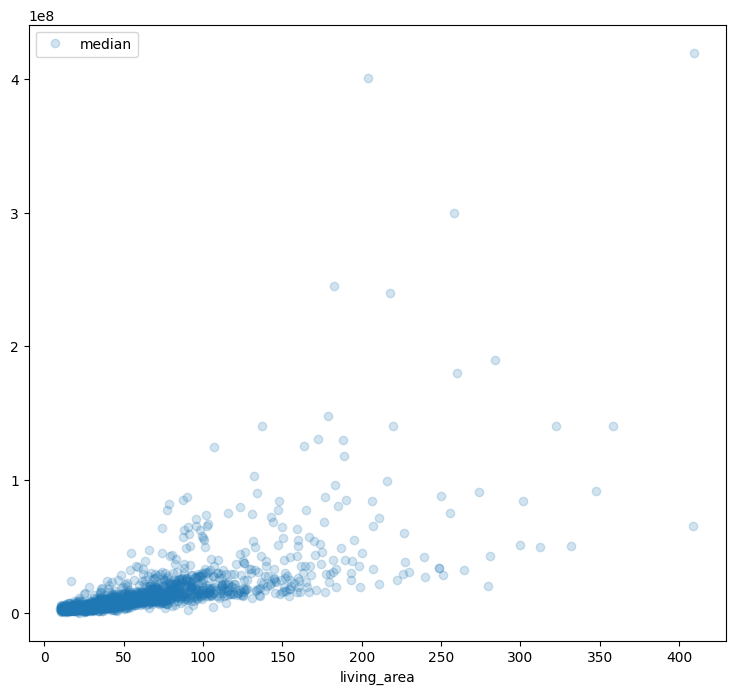

In [131]:
liv_area_price = piv_table('living_area')
liv_area_price.plot(y='median', style='o', figsize=(9,8), alpha=0.2);

Корреляция здесь тоже прослеживается, и на первый взгляд даже сильнее, чем с общей площадью. Рассчитаем коэф Пирсона для проверки

In [132]:
data['living_area'].corr(data['last_price'])

0.5867533577415757

Получаем 0.58 - совсем чуть - чуть меньше, чем с общей площадью, но все равно достаточно высокий показатель, можно говорить о непосредственном влиянии жилой площади на цену.

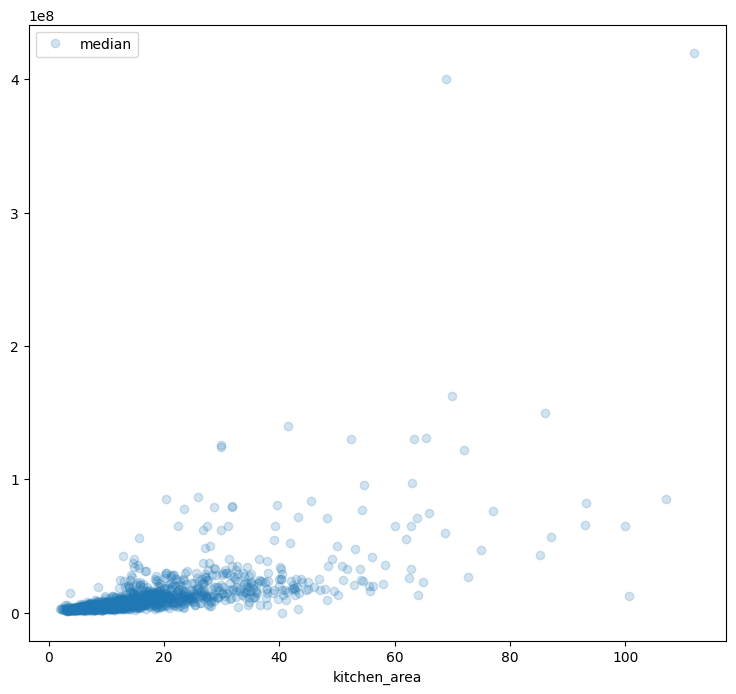

In [133]:
kitch_area_price = piv_table('kitchen_area')
kitch_area_price.plot(y='median', style='o', figsize=(9,8), alpha=0.2);

Видна корреляция, рассеивание точек совсем небольшое. Что скажет коэффициент Пирсона?

In [134]:
data['kitchen_area'].corr(data['last_price'])

0.5148286427491655

Получаем 0.51 - тоже достаточно высокий. Можно говорить об умеренном влиянии площади кухни на цену.

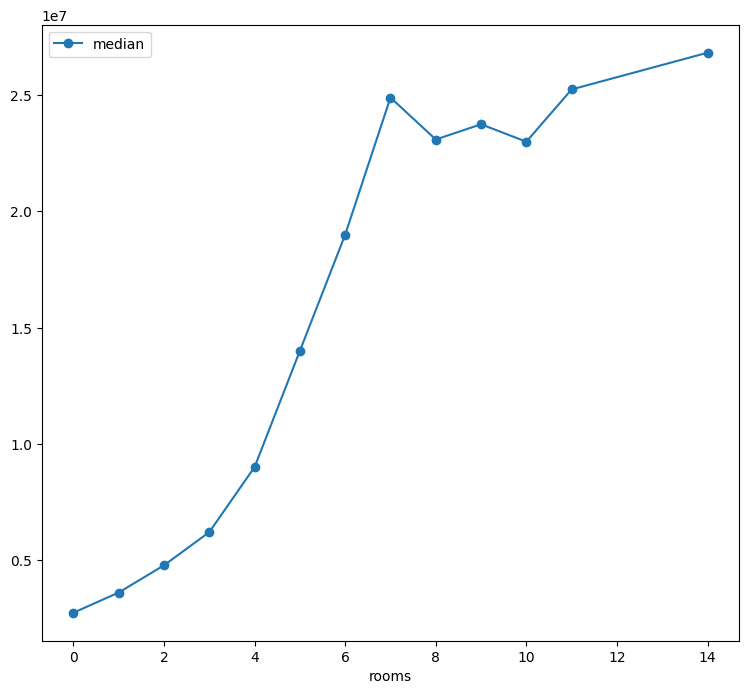

In [136]:
room_area_price = piv_table('rooms')
room_area_price = room_area_price.query('count > 1')
room_area_price.plot(y='median', style='-o', figsize=(9,8));

На графике заметно, что цена очень сильно возрастает по мере возрастания числа комнат от 0 до 7, затем немного падает и растет намного медленнее. Корелляция явно есть, но не очень высокая, явно не такая, как у площади.

In [137]:
data['rooms'].corr(data['last_price'])

0.3634908842033551

0.36 - корреляция конечно есть, но не ярко выраженная.

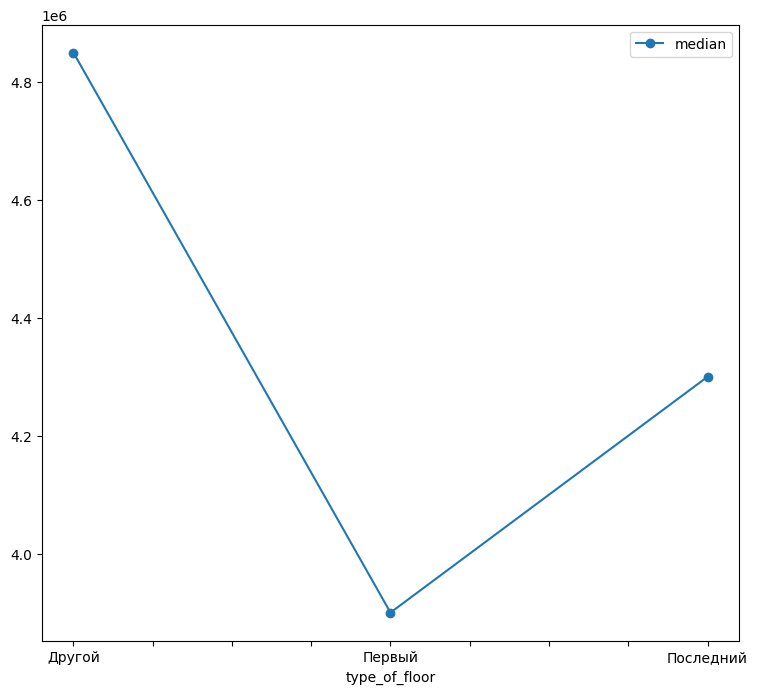

In [139]:
floor_area_price = piv_table('type_of_floor')
floor_area_price.plot(y='median', style='-o', figsize=(9,8));

График четко демонстрирует, что цена очень сильно зависит от того, на каком этаже квартира. Так, квартиры на последнем этаже дешевле, чем квартиры на в середине дома примерно на 10%, а на первом этаже - на 20%! Всё так, квартиры на первом этаже всегда были не в почёте, из - за многих факторов, ровно также, как и на последнем.

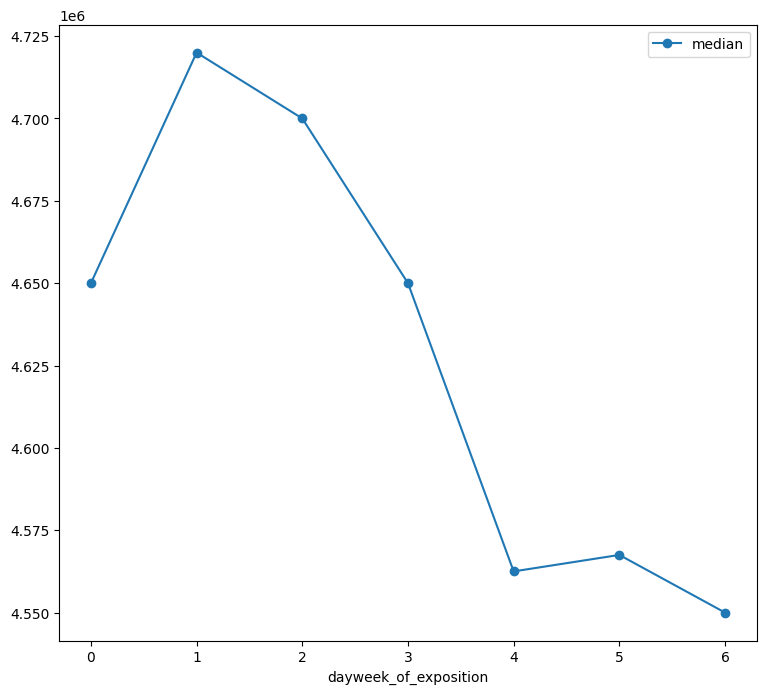

In [140]:
dayweek_area_price = piv_table('dayweek_of_exposition')
dayweek_area_price.plot(y='median', style='-o', figsize=(9,8));

Оказывается, помимо того, что на выходных реже всего размещаются объявления, так еще и квартиры, размещенные на выходных, продаются дешевле. А вот объявления, размещенные во вторник закрываются по самой высокой цене. 

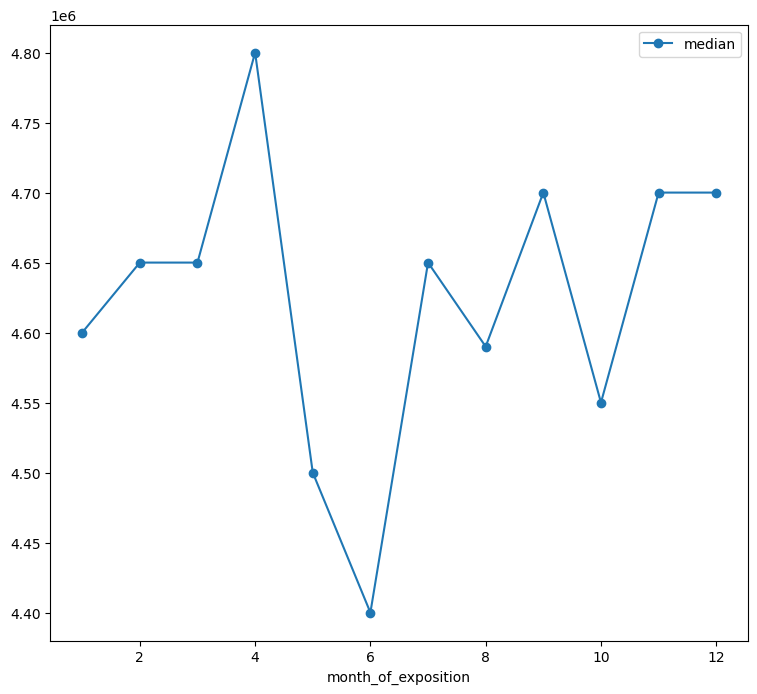

In [141]:
month_area_price = piv_table('month_of_exposition')
month_area_price.plot(y='median', style='-o', figsize=(9,8));

Меньше всего объявлений было выставлено в мае, в июне немногим больше, а теперь оказывается, что квартиры в июне продаются дешевле. Наверное это связано с тем, что в этот период и продавцы, и покупатели менее активны. А так как покупателей мало, продавцы готовы снижать цену. Заметна странная тенденция для месяца и года - в дни или месяцы, когда публикуется мало объявлений, обычно недвижимость продаётся дешевле. Так как в апреле недвижимость продавалась дороже всего, то можно предположить, что было очень много покупателей, из - за которых продавцы как раз и повышали цену. Это бы также объяснило почему в мае так мало объявлений и такие низкие цены - так как нет покупателей.

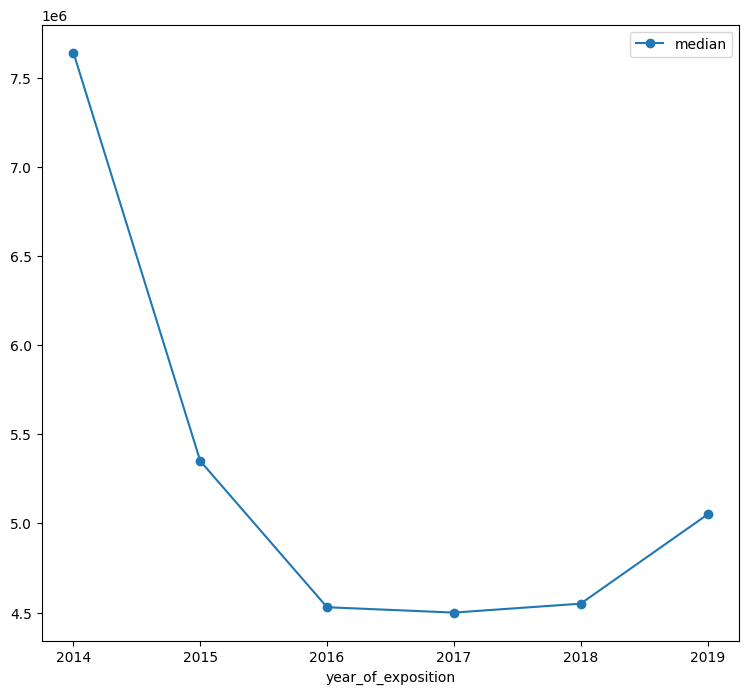

In [142]:
year_area_price = piv_table('year_of_exposition')
year_area_price.plot(y='median', style='-o', figsize=(9,8));

Цена недвижимости упала очень сильно с 2014 года. Причиной этому послужил кризис 2014 года, тогда и правда обвалилась недвижимость, всё из - за санкций и падения цен на нефть.

**Вывод**

Итак, судя по построенным графикам и рассчитаным коэффициентам Пирсона, самым главным параметром, влияющим на цену является общая площадь, затем жилая площадь и только потом площадь кухни. Количество комнат не сильно влияет на этот параметр, но я думаю это из - за того, что в нашей выборке большинство квартир 2 - 3 комнатные. Явно определено влияние этажа квартиры - квартиры на первом и последнем этажах дешевле других на 20 и 10 процентов соотвественно. Квартиры продаются дороже по вторникам и в апреле. С 2014 года цена на недвижимость обрушилась, но с 2018 идет на повышение.

#### Средняя цена квадратного метра

In [143]:
top10 = list(data['locality_name'].value_counts().index)[:10]
print('10 населенных пунктов с наибольшим числом объявлений:', top10)

10 населенных пунктов с наибольшим числом объявлений: ['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг']


In [144]:
price_dict = {}
for city in top10:
    price_dict[city] = data[data['locality_name'] == city]['price_per_metr'].mean()
price_dict = dict(sorted(price_dict.items(), key=lambda item: item[1]))
for city, price in price_dict.items():
    print('Цена одного квадратного метра в населенном пункте', city, 'равна', price)

Цена одного квадратного метра в населенном пункте Выборг равна 58141.90915331862
Цена одного квадратного метра в населенном пункте Всеволожск равна 68654.4739860316
Цена одного квадратного метра в населенном пункте Гатчина равна 68746.14676333922
Цена одного квадратного метра в населенном пункте Колпино равна 75424.57909803945
Цена одного квадратного метра в населенном пункте Шушары равна 78703.26324160109
Цена одного квадратного метра в населенном пункте Мурино равна 86061.67701443135
Цена одного квадратного метра в населенном пункте Парголово равна 90175.91345801107
Цена одного квадратного метра в населенном пункте Кудрово равна 95324.93054392203
Цена одного квадратного метра в населенном пункте Пушкин равна 103125.81929072196
Цена одного квадратного метра в населенном пункте Санкт-Петербург равна 114767.60569955496


**Вывод**

Несложно увидеть, что самая высокая цена, вполне ожидаемо, в Санкт - Петербурге - 114000, а вот самая дешевая в Выборге, всего 58000.

#### Цена километра

In [145]:
spb = data[data['locality_name'] == 'Санкт-Петербург']
price_of_km = spb.pivot_table(index='distance_center_km', values='last_price', aggfunc=['mean'])
price_of_km.columns = ['mean']

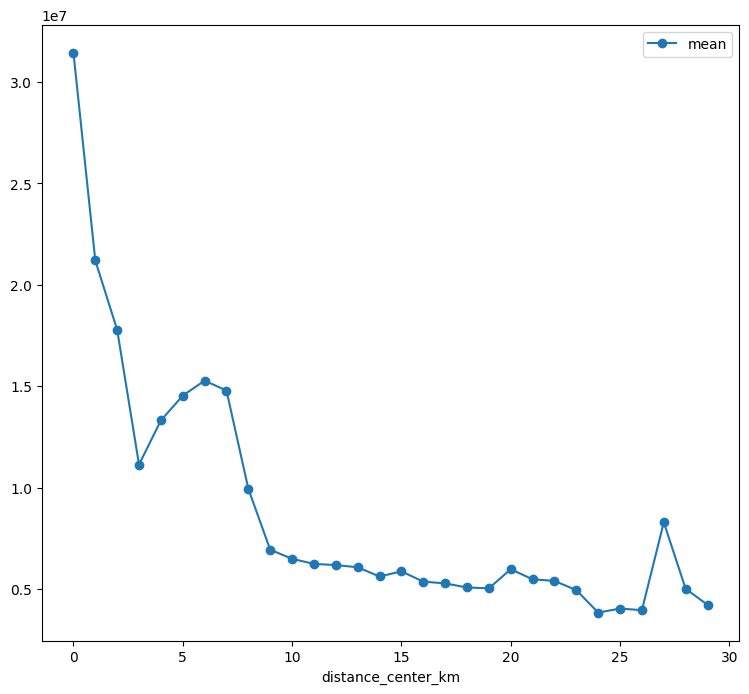

In [147]:
price_of_km.plot(style='-o', figsize=(9, 8));

In [148]:
prices = price_of_km['mean'].to_list()
dif_price = []
for i in range(len(prices) - 1):
    dif_price.append(prices[i] - prices[i+1])
for i in range(len(dif_price)):
    print('За', i + 1, 'километр цена изменилась на', dif_price[i])
print('Средняя цена увеличения цены недвижимости на 1 километр', pd.Series(dif_price).mean())
print('Медианная цена увеличения цены недвижимости на 1 километр', pd.Series(dif_price).median())

За 1 километр цена изменилась на 10242395.02372685
За 2 километр цена изменилась на 3418401.215221774
За 3 километр цена изменилась на 6642178.206026435
За 4 километр цена изменилась на -2175049.7372280117
За 5 километр цена изменилась на -1223614.943231441
За 6 километр цена изменилась на -737052.2752653826
За 7 километр цена изменилась на 486598.0141529385
За 8 километр цена изменилась на 4844240.272818437
За 9 километр цена изменилась на 3000361.4972154116
За 10 километр цена изменилась на 446539.3461478017
За 11 километр цена изменилась на 251304.5826071743
За 12 километр цена изменилась на 56652.79294703994
За 13 километр цена изменилась на 107418.09707095008
За 14 километр цена изменилась на 456035.3624676196
За 15 километр цена изменилась на -253181.95572938304
За 16 километр цена изменилась на 505898.1640147483
За 17 километр цена изменилась на 87597.56374732591
За 18 километр цена изменилась на 201063.3033024827
За 19 километр цена изменилась на 42773.853890362196
За 20 киломе

**Вывод**

Заметно молниеносное снижение цены в 3 раза за первые 3 километра от центра. Затем цена не сильно возрастает, но до 10 километра быстро падает до 7,5 миллионов и в таком режиме уже постепенно опускается. По графику можно с уверенностью сказать, что цены в центре перегреты.

### Общий вывод

В ходе проделанного исследования данные были очищены от пропусков(где это возможно) и дубликатов, были изменены типы данных, из колонок были удалены аномальные значения, были рассчитаны и добавлены некоторые новые параметры. Досконально изучены самые главные параметры квартир и сделаны выводы о их корреляции с ценой. Так, на цену больше всего влияет общий метраж квартиры, а также жилая площадь и площадь кухни, количество комнат, высота потолков, этаж квартиры и удаленность от центра. 

Определены периоды наибольшей активности продавцов - по месяцам это февраль, а по дням недели - четверг. Также выяснилось, что квартиры продаются дороже по вторникам, а если по месяцам - то в апреле. 

Типичное объявление в этих данных было о продаже двухкомнатной квартиры в Санкт - Петербурге, площадью 50 квадратных метров, с высотой потолков 2,5м, этажность - 5 этаж, а асстояние до центра - около 13км. Хозяин требует около 5 миллионов за эту квартиру. Выяснено, что типичное время продажи квартиры - около 100 дней, а нормальное время продажи - до 500 дней. Также обнаружена интересная аномалия - много объявлений считались закрытыми на 45, 60 и 90 день, хотя на самом деле люди снимали их, чтобы обойти ограничение площадки. 

Было отслежено влияние кризиса 2014 года на недвижимость - сокрушительное падение. Из всех месторасположений жилья было выбрано 10, объявлений по которым было больше всего, для каждого из этих мест была посчитана средняя цена квадратного метра жилья, самым большим параметр оказался для Санкт-Петербурга - 115000, а самым дешевым для Выборга, всего лишь 58000. 

Отслежено влияние удаленности от центра: в среднем каждый километр от центре уменьшает цену на 938000 у.е.